## 🧠 Non-Inferiority & Performance Analysis: AI vs. Human

This notebook computes a non-inferiority test for multiple AI classifiers (AI1-AI4) against a single Human classifier (H1) using a **paired, stratified bootstrap** on both the **Weighted F1-score (W-F1)** and **Unweighted F1-score**.

It also includes:
1.  **Non-Inferiority Tests:** Both weighted (by `log(1 + concept_count)`) and unweighted.
2.  **Performance Metrics:** Weighted and unweighted F-score, precision, and recall, calculated overall and per disease.
3.  **Agreement Plots:** Stacked bar charts visualizing True Positives, False Positives, and False Negatives for all classifiers, overall and per disease.

### 1. Configuration
Set the paths and parameters for the test.

In [20]:
import pandas as pd
import numpy as np
import os
import glob
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")

# ----------------------------------------------------------------
# ⚙️ CONFIGURATION
# ----------------------------------------------------------------

# --- Statistical Parameters ---
# ⚠️ Define your non-inferiority margin (Δ).
NON_INFERIORITY_MARGIN = 0.05
BOOTSTRAP_ITERATIONS = 10000
ALPHA = 0.05  # For a 95% one-sided CI (or 90% two-sided CI)

# --- Classifier IDs ---
HUMAN_ARM_ID = "H1"
AI_ARM_IDS = ["AI1", "AI2", "AI3", "AI4"] # Test all AI arms

# --- Path Configuration ---
try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()  # Fallback for interactive notebooks

GOLD_DIR = os.path.join(SCRIPT_DIR, "results", "phaseA_gold_final")
CONCEPTSET_DIR = os.path.abspath(os.path.join(SCRIPT_DIR, "..", "ConceptSets"))
RECORD_COUNT_PATH = os.path.join(SCRIPT_DIR, "ConceptRecordCounts.csv")

print(f"Notebook directory: {SCRIPT_DIR}")
print(f"Gold Standard directory: {GOLD_DIR}")
print(f"ConceptSet directory: {CONCEPTSET_DIR}")
print(f"Record Count file: {RECORD_COUNT_PATH}")
print(f"---")
print(f"Comparing AI arms: {', '.join(AI_ARM_IDS)}")
print(f"Against Human arm: {HUMAN_ARM_ID}")
print(f"Non-Inferiority Margin (Δ): {NON_INFERIORITY_MARGIN}")
print(f"Test: F1(AI) - F1(Human) > -{NON_INFERIORITY_MARGIN}")

Notebook directory: /Users/schuemie/git/MindMeetsMachines/Materials/Scripts
Gold Standard directory: /Users/schuemie/git/MindMeetsMachines/Materials/Scripts/results/phaseA_gold_final
ConceptSet directory: /Users/schuemie/git/MindMeetsMachines/Materials/ConceptSets
Record Count file: /Users/schuemie/git/MindMeetsMachines/Materials/Scripts/ConceptRecordCounts.csv
---
Comparing AI arms: AI1, AI2, AI3, AI4
Against Human arm: H1
Non-Inferiority Margin (Δ): 0.05
Test: F1(AI) - F1(Human) > -0.05


### 2. Helper Functions
These functions find and load the concept files for each task and classifier.

In [21]:
def find_concept_file(disease_prefix, arm_id, concept_dir):
    """Finds the includedConcepts.csv file for a specific disease prefix and arm ID."""
    pattern = re.compile(rf"\[{disease_prefix}\](.*?)\[{arm_id}\]", re.IGNORECASE)
    online_pattern = re.compile(r"ONLINE", re.IGNORECASE)
    
    for folder_name in os.listdir(concept_dir):
        folder_path = os.path.join(concept_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue
            
        if pattern.search(folder_name) and not online_pattern.search(folder_name):
            csv_path = os.path.join(folder_path, "includedConcepts.csv")
            if os.path.exists(csv_path):
                return csv_path
    return None

def load_concepts(file_path):
    """Loads concept IDs from a CSV file into a set."""
    if file_path is None or not os.path.exists(file_path):
        print(f"⚠️ File not found, returning empty set: {file_path}")
        return set()
    try:
        df = pd.read_csv(file_path, dtype=str)
        df.columns = [c.strip() for c in df.columns]
        
        target_col = None
        for col in df.columns:
            if col.lower() == "conceptid":
                target_col = col
                break
        
        if target_col is None:
             for col in df.columns:
                 if "concept" in col.lower() and "id" in col.lower():
                    target_col = col
                    break
        
        if target_col is None:
            print(f"⚠️ Could not find 'conceptId' in {file_path}. Using first column.")
            target_col = df.columns[0]
            
        vals = df[target_col].dropna().astype(str).str.strip().str.replace(r"\.0+$", "", regex=True)
        return set(vals[vals != ""])
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return set()


### 3. Load Concept Weights
Load the `ConceptRecordCounts.csv` file and create the `log(1 + count)` weight for each concept.

In [22]:
if not os.path.exists(RECORD_COUNT_PATH):
    print(f"❌ CRITICAL ERROR: ConceptRecordCounts.csv not found at {RECORD_COUNT_PATH}")
    print("Please ensure the file is in the correct location.")
    df_counts = pd.DataFrame(columns=["concept_id", "record_count"])
else:
    df_counts = pd.read_csv(RECORD_COUNT_PATH, dtype=str)
    print(f"Loaded {len(df_counts)} records from {RECORD_COUNT_PATH}")

# Ensure correct dtypes
df_counts['concept_id'] = df_counts['concept_id'].astype(str).str.strip().str.replace(r"\.0+$", "", regex=True)
df_counts['record_count'] = pd.to_numeric(df_counts['record_count'], errors='coerce').fillna(0)

# Calculate the log(1+count) weight
df_counts['weight'] = np.log1p(df_counts['record_count'])

# Create a lookup dictionary (Series) for fast mapping
weight_lookup = df_counts.set_index('concept_id')['weight']

print(f"Created weight lookup for {len(weight_lookup)} concepts.")
display(weight_lookup.head())

Loaded 119395 records from /Users/schuemie/git/MindMeetsMachines/Materials/Scripts/ConceptRecordCounts.csv
Created weight lookup for 119395 concepts.


concept_id
5083    16.402596
8507    19.775147
8515    15.788488
8516    17.678701
8522    11.587764
Name: weight, dtype: float64

### 4. Build Master Item-Level Dataset

We now loop through all tasks (diseases) and build one large DataFrame. Each row represents a single concept (item) and its classification by all parties, plus its concept weight.

In [23]:
all_items = []
all_tasks_found = []
classifier_columns = ['human'] + [arm.lower() for arm in AI_ARM_IDS]

gold_files = glob.glob(os.path.join(GOLD_DIR, "*_Gold_Standard_FINAL.csv"))
print(f"Found {len(gold_files)} Gold Standard files.")

for gs_file in gold_files:
    base_name = os.path.basename(gs_file)
    match = re.search(r"^(C\d+)", base_name, re.IGNORECASE)
    if not match:
        print(f"Skipping {base_name}: Could not parse disease prefix.")
        continue
        
    disease_prefix = match.group(1)
    task_name = base_name.replace("_Gold_Standard_FINAL.csv", "")
    
    # Find corresponding classifier files
    human_file = find_concept_file(disease_prefix, HUMAN_ARM_ID, CONCEPTSET_DIR)
    ai_files = {arm: find_concept_file(disease_prefix, arm, CONCEPTSET_DIR) for arm in AI_ARM_IDS}
    
    all_files_found = human_file is not None and all(ai_files.values())
    if not all_files_found:
        print(f"\n⚠️ Skipping {task_name} (prefix {disease_prefix}):")
        if not human_file: 
            print(f"  - Missing file for {HUMAN_ARM_ID}")
        for arm, f in ai_files.items():
            if f is None:
                print(f"  - Missing file for {arm}")
        continue
        
    # Load concept sets
    gs_concepts = load_concepts(gs_file)
    human_concepts = load_concepts(human_file)
    ai_concepts = {arm: load_concepts(f) for arm, f in ai_files.items()}
    
    # Define the 'universe' of items for this task
    universe = gs_concepts | human_concepts
    for arm_concepts in ai_concepts.values():
        universe.update(arm_concepts)
    
    if not universe:
        print(f"Skipping {task_name}: No concepts found.")
        continue

    # Create item-level records
    for concept_id in universe:
        record = {
            'task_id': task_name,
            'concept_id': concept_id,
            'gold': concept_id in gs_concepts,
            'human': concept_id in human_concepts,
            'weight': weight_lookup.get(concept_id, 0.0) # Get weight, default to 0.0 (log(1+0))
        }
        # Add AI classifications
        for arm in AI_ARM_IDS:
            record[arm.lower()] = concept_id in ai_concepts[arm]
        
        all_items.append(record)
    
    print(f"Processed {task_name}: {len(universe)} items.")
    all_tasks_found.append(task_name)

# Create the final DataFrame
df_items = pd.DataFrame(all_items)

print("\n" + "="*30)
print(f"Master dataset created.")
print(f"Total tasks included: {len(all_tasks_found)}")
print(f"Total items (concepts): {len(df_items)}")

# ----------------------------------------------------------------
# ⚠️ BUG FIX: Check if df_items is empty before proceeding
# ----------------------------------------------------------------
if df_items.empty:
    print("\n❌ CRITICAL ERROR: No data was loaded into the master DataFrame.")
    print("This happens if no tasks were processed (e.g., missing Gold Standard or arm files).")
    print("Please check the log output above. Halting execution.")
    # This will cause a NameError if you try to run subsequent cells, which is intended.
    raise SystemExit("Stopping notebook due to empty master DataFrame.")
else:
    display(df_items.head())


Found 6 Gold Standard files.
Processed C04_DeepVeinThrombosis: 267 items.
Processed C01_SLE: 108 items.

⚠️ Skipping C03_DiabetesMacularEdema (prefix C03):
  - Missing file for AI4
Processed C07_SystemicSclerosis: 50 items.

⚠️ Skipping C02_RheumatoidArthritis (prefix C02):
  - Missing file for AI4
Processed C06_Uveitis: 269 items.

Master dataset created.
Total tasks included: 4
Total items (concepts): 694


,task_id,concept_id,gold,human,weight,ai1,ai2,ai3,ai4
0,C04_DeepVeinThrombosis,762422,False,True,0.0,False,True,True,False
1,C04_DeepVeinThrombosis,37173538,False,False,0.0,False,False,True,False
2,C04_DeepVeinThrombosis,3295526,False,True,0.0,False,False,False,False
3,C04_DeepVeinThrombosis,3172731,False,False,0.0,False,True,False,False
4,C04_DeepVeinThrombosis,4309333,True,True,0.0,False,False,True,False


### 5. Define F1-Score Calculation Functions

These functions compute the aggregate F1-scores for the bootstrap loops.
We need two versions: one for **Weighted F1** and one for **Unweighted F1**.

In [24]:
def calculate_weighted_f1_scores(df, classifier_cols):
    """Calculates aggregate Weighted F1 scores for all specified classifiers."""
    
    scores = {}
    # Get the gold and weight columns ONCE, as they are constant for all classifiers
    is_gold = df['gold']
    weights = df['weight']
    
    for clf in classifier_cols:
        # Create boolean mask for this classifier
        is_clf = df[clf]
        
        # Multiply the boolean mask by the weight, then sum
        wtp = (is_gold & is_clf) * weights
        wfp = (~is_gold & is_clf) * weights
        wfn = (is_gold & ~is_clf) * weights
        
        # Sum the weights
        WTP = wtp.sum()
        WFP = wfp.sum()
        WFN = wfn.sum()
        
        denominator = (2 * WTP + WFP + WFN)
        f1 = (2 * WTP) / denominator if denominator > 0 else 0
        scores[clf] = f1
        
    return scores

def calculate_unweighted_f1_scores(df, classifier_cols):
    """Calculates aggregate Unweighted F1 scores for all specified classifiers."""
    
    scores = {}
    # Get the gold column ONCE, as it is constant for all classifiers
    is_gold = df['gold']
    
    for clf in classifier_cols:
        # Create boolean mask for this classifier
        is_clf = df[clf]
        
        # Count the booleans
        TP = (is_gold & is_clf).sum()
        FP = (~is_gold & is_clf).sum()
        FN = (is_gold & ~is_clf).sum()
        
        denominator = (2 * TP + FP + FN)
        f1 = (2 * TP) / denominator if denominator > 0 else 0
        scores[clf] = f1
        
    return scores

### 6. Run Stratified Bootstrap (Weighted F1)

This is the core of the first test. We loop 10,000 times. In each loop, we:
1.  Create a new dataset by sampling *with replacement* from each task.
2.  Calculate the aggregate **Weighted F1 scores** for this new dataset.
3.  Store the difference for each AI: $W-F1_{AI_n} - W-F1_{Human}$.

In [25]:
# Get the original, observed Weighted F1 scores and differences
obs_scores_w = calculate_weighted_f1_scores(df_items, classifier_columns)
obs_diffs_w = {}

print("--- Observed Weighted F1 Scores ---")
print(f"Observed W-F1 ({HUMAN_ARM_ID}): {obs_scores_w['human']:.4f}")
for arm in AI_ARM_IDS:
    arm_key = arm.lower()
    obs_diff = obs_scores_w[arm_key] - obs_scores_w['human']
    obs_diffs_w[arm] = obs_diff
    print(f"Observed W-F1 ({arm}):     {obs_scores_w[arm_key]:.4f} (Diff: {obs_diff:+.4f})")

# Initialize storage for bootstrap differences
bootstrap_diffs_w = {arm: [] for arm in AI_ARM_IDS}

tasks = df_items['task_id'].unique()
task_indices = {task: df_items[df_items['task_id'] == task].index for task in tasks}

print(f"\nRunning {BOOTSTRAP_ITERATIONS} bootstrap iterations for Weighted F1...")

# Set a fixed random seed for reproducible results
np.random.seed(42)

for _ in tqdm(range(BOOTSTRAP_ITERATIONS), desc="Weighted F1 Bootstrap"):
    # Create stratified sample
    resampled_indices = []
    for task in tasks:
        indices = task_indices[task]
        # Sample with replacement from this task's items
        sample = np.random.choice(indices, size=len(indices), replace=True)
        resampled_indices.append(sample)
    
    # Combine indices and create the bootstrap dataset
    df_boot = df_items.loc[np.concatenate(resampled_indices)]
    
    # Calculate Weighted F1 scores for this sample
    scores = calculate_weighted_f1_scores(df_boot, classifier_columns)
    f1_h = scores['human']
    
    # Store the difference for each AI arm
    for arm in AI_ARM_IDS:
        f1_ai = scores[arm.lower()]
        bootstrap_diffs_w[arm].append(f1_ai - f1_h)

print("Weighted F1 Bootstrap complete.")

--- Observed Weighted F1 Scores ---
Observed W-F1 (H1): 0.7749
Observed W-F1 (AI1):     0.6081 (Diff: -0.1668)
Observed W-F1 (AI2):     0.7325 (Diff: -0.0424)
Observed W-F1 (AI3):     0.7827 (Diff: +0.0078)
Observed W-F1 (AI4):     0.6340 (Diff: -0.1410)

Running 10000 bootstrap iterations for Weighted F1...


Weighted F1 Bootstrap:   0%|          | 0/10000 [00:00<?, ?it/s]

Weighted F1 Bootstrap complete.


### 7. Results: Weighted F1 Non-Inferiority

We now analyze the 10,000 Weighted F1 differences for *each AI arm* to build their confidence intervals and make a conclusion.

In [26]:
print("="*50)
print("    FINAL NON-INFERIORITY TEST RESULTS (WEIGHTED F1)")
print("="*50)

for arm in AI_ARM_IDS:
    arm_key = arm.lower()
    diffs_arr = np.array(bootstrap_diffs_w[arm])
    
    # For a one-sided test at ALPHA=0.05, we need the 5th percentile.
    # This corresponds to the lower bound of a 90% two-sided CI.
    ci_lower = np.percentile(diffs_arr, 100 * ALPHA)
    ci_upper = np.percentile(diffs_arr, 100 * (1 - ALPHA))
    mean_diff = np.mean(diffs_arr)
    
    # --- The Non-Inferiority Test ---
    # We REJECT the null (H0: AI is inferior) if the lower bound 
    # of our CI is GREATER than the negative margin.
    is_non_inferior = ci_lower > -NON_INFERIORITY_MARGIN
    
    # --- Final Report for this Arm ---
    print(f"\n--- [ {arm} vs. {HUMAN_ARM_ID} ] ---")
    print(f"Non-Inferiority Margin (Δ): {NON_INFERIORITY_MARGIN:.4f}")
    print(f"Hypothesis (H1):      W-F1({arm}) - W-F1({HUMAN_ARM_ID}) > -{NON_INFERIORITY_MARGIN}")
    print("-"*40)
    print(f"Observed W-F1 ({HUMAN_ARM_ID}):  {obs_scores_w['human']:.4f}")
    print(f"Observed W-F1 ({arm}):     {obs_scores_w[arm_key]:.4f}")
    print(f"Observed Difference:  {obs_diffs_w[arm]:+.4f}")
    print(f"Mean Bootstrapped Diff: {mean_diff:+.4f}")
    print(f"90% Confidence Interval: [{ci_lower:+.4f}, {ci_upper:+.4f}]")
    print("-"*40)
    print(f"Test Condition:       Lower Bound > -Margin")
    print(f"Result:               {ci_lower:+.4f} > {-NON_INFERIORITY_MARGIN}")
    print("\n   CONCLUSION (Weighted F1):")
    if is_non_inferior:
        print(f"    ✅ The {arm} classifier IS non-inferior to the {HUMAN_ARM_ID} classifier.")
        print("       (The lower bound of the 90% CI is above the non-inferiority margin.)")
    else:
        print(f"    ❌ The {arm} classifier is NOT non-inferior to the {HUMAN_ARM_ID} classifier.")
        print("       (The lower bound of the 90% CI is at or below the non-inferiority margin.)")
    print("-"*40)

print("\n" + "="*50)
print("    Weighted F1 tests complete.")
print("="*50)


    FINAL NON-INFERIORITY TEST RESULTS (WEIGHTED F1)

--- [ AI1 vs. H1 ] ---
Non-Inferiority Margin (Δ): 0.0500
Hypothesis (H1):      W-F1(AI1) - W-F1(H1) > -0.05
----------------------------------------
Observed W-F1 (H1):  0.7749
Observed W-F1 (AI1):     0.6081
Observed Difference:  -0.1668
Mean Bootstrapped Diff: -0.1681
90% Confidence Interval: [-0.2645, -0.0735]
----------------------------------------
Test Condition:       Lower Bound > -Margin
Result:               -0.2645 > -0.05

   CONCLUSION (Weighted F1):
    ❌ The AI1 classifier is NOT non-inferior to the H1 classifier.
       (The lower bound of the 90% CI is at or below the non-inferiority margin.)
----------------------------------------

--- [ AI2 vs. H1 ] ---
Non-Inferiority Margin (Δ): 0.0500
Hypothesis (H1):      W-F1(AI2) - W-F1(H1) > -0.05
----------------------------------------
Observed W-F1 (H1):  0.7749
Observed W-F1 (AI2):     0.7325
Observed Difference:  -0.0424
Mean Bootstrapped Diff: -0.0426
90% Confidence

### 8. Run Stratified Bootstrap (Unweighted F1)

This is the second test, using the same methodology but with the **Unweighted F1-score**.

In [27]:
# Get the original, observed Unweighted F1 scores and differences
obs_scores_u = calculate_unweighted_f1_scores(df_items, classifier_columns)
obs_diffs_u = {}

print("--- Observed Unweighted F1 Scores ---")
print(f"Observed F1 ({HUMAN_ARM_ID}): {obs_scores_u['human']:.4f}")
for arm in AI_ARM_IDS:
    arm_key = arm.lower()
    obs_diff = obs_scores_u[arm_key] - obs_scores_u['human']
    obs_diffs_u[arm] = obs_diff
    print(f"Observed F1 ({arm}):     {obs_scores_u[arm_key]:.4f} (Diff: {obs_diff:+.4f})")

# Initialize storage for bootstrap differences
bootstrap_diffs_u = {arm: [] for arm in AI_ARM_IDS}

# tasks and task_indices are already defined from the previous bootstrap

print(f"\nRunning {BOOTSTRAP_ITERATIONS} bootstrap iterations for Unweighted F1...")

# Set a fixed random seed for reproducible results
np.random.seed(42)

for _ in tqdm(range(BOOTSTRAP_ITERATIONS), desc="Unweighted F1 Bootstrap"):
    # Create stratified sample
    resampled_indices = []
    for task in tasks:
        indices = task_indices[task]
        # Sample with replacement from this task's items
        sample = np.random.choice(indices, size=len(indices), replace=True)
        resampled_indices.append(sample)
    
    # Combine indices and create the bootstrap dataset
    df_boot = df_items.loc[np.concatenate(resampled_indices)]
    
    # Calculate Unweighted F1 scores for this sample
    scores = calculate_unweighted_f1_scores(df_boot, classifier_columns)
    f1_h = scores['human']
    
    # Store the difference for each AI arm
    for arm in AI_ARM_IDS:
        f1_ai = scores[arm.lower()]
        bootstrap_diffs_u[arm].append(f1_ai - f1_h)

print("Unweighted F1 Bootstrap complete.")

--- Observed Unweighted F1 Scores ---
Observed F1 (H1): 0.6393
Observed F1 (AI1):     0.4273 (Diff: -0.2119)
Observed F1 (AI2):     0.5778 (Diff: -0.0614)
Observed F1 (AI3):     0.7380 (Diff: +0.0988)
Observed F1 (AI4):     0.5693 (Diff: -0.0699)

Running 10000 bootstrap iterations for Unweighted F1...


Unweighted F1 Bootstrap:   0%|          | 0/10000 [00:00<?, ?it/s]

Unweighted F1 Bootstrap complete.


### 9. Results: Unweighted F1 Non-Inferiority

We now analyze the 10,000 Unweighted F1 differences to make a conclusion.

In [28]:
print("="*50)
print("    FINAL NON-INFERIORITY TEST RESULTS (UNWEIGHTED F1)")
print("="*50)

for arm in AI_ARM_IDS:
    arm_key = arm.lower()
    diffs_arr = np.array(bootstrap_diffs_u[arm])
    
    # For a one-sided test at ALPHA=0.05, we need the 5th percentile.
    ci_lower = np.percentile(diffs_arr, 100 * ALPHA)
    ci_upper = np.percentile(diffs_arr, 100 * (1 - ALPHA))
    mean_diff = np.mean(diffs_arr)
    
    # --- The Non-Inferiority Test ---
    is_non_inferior = ci_lower > -NON_INFERIORITY_MARGIN
    
    # --- Final Report for this Arm ---
    print(f"\n--- [ {arm} vs. {HUMAN_ARM_ID} ] ---")
    print(f"Non-Inferiority Margin (Δ): {NON_INFERIORITY_MARGIN:.4f}")
    print(f"Hypothesis (H1):      F1({arm}) - F1({HUMAN_ARM_ID}) > -{NON_INFERIORITY_MARGIN}")
    print("-"*40)
    print(f"Observed F1 ({HUMAN_ARM_ID}):  {obs_scores_u['human']:.4f}")
    print(f"Observed F1 ({arm}):     {obs_scores_u[arm_key]:.4f}")
    print(f"Observed Difference:  {obs_diffs_u[arm]:+.4f}")
    print(f"Mean Bootstrapped Diff: {mean_diff:+.4f}")
    print(f"90% Confidence Interval: [{ci_lower:+.4f}, {ci_upper:+.4f}]")
    print("-"*40)
    print(f"Test Condition:       Lower Bound > -Margin")
    print(f"Result:               {ci_lower:+.4f} > {-NON_INFERIORITY_MARGIN}")
    print("\n   CONCLUSION (Unweighted F1):")
    if is_non_inferior:
        print(f"    ✅ The {arm} classifier IS non-inferior to the {HUMAN_ARM_ID} classifier.")
        print("       (The lower bound of the 90% CI is above the non-inferiority margin.)")
    else:
        print(f"    ❌ The {arm} classifier is NOT non-inferior to the {HUMAN_ARM_ID} classifier.")
        print("       (The lower bound of the 90% CI is at or below the non-inferiority margin.)")
    print("-"*40)

print("\n" + "="*50)
print("    All tests complete.")
print("="*50)


    FINAL NON-INFERIORITY TEST RESULTS (UNWEIGHTED F1)

--- [ AI1 vs. H1 ] ---
Non-Inferiority Margin (Δ): 0.0500
Hypothesis (H1):      F1(AI1) - F1(H1) > -0.05
----------------------------------------
Observed F1 (H1):  0.6393
Observed F1 (AI1):     0.4273
Observed Difference:  -0.2119
Mean Bootstrapped Diff: -0.2123
90% Confidence Interval: [-0.2618, -0.1638]
----------------------------------------
Test Condition:       Lower Bound > -Margin
Result:               -0.2618 > -0.05

   CONCLUSION (Unweighted F1):
    ❌ The AI1 classifier is NOT non-inferior to the H1 classifier.
       (The lower bound of the 90% CI is at or below the non-inferiority margin.)
----------------------------------------

--- [ AI2 vs. H1 ] ---
Non-Inferiority Margin (Δ): 0.0500
Hypothesis (H1):      F1(AI2) - F1(H1) > -0.05
----------------------------------------
Observed F1 (H1):  0.6393
Observed F1 (AI2):     0.5778
Observed Difference:  -0.0614
Mean Bootstrapped Diff: -0.0615
90% Confidence Interval: [

### 10. Overall & Per-Disease Performance Metrics

This section calculates the point estimates for weighted and unweighted precision, recall, and F1-score for all classifiers.

1.  **Overall Metrics:** Calculated across all tasks combined.
2.  **Per-Disease Metrics:** Calculated individually for each task.

In [29]:
def calculate_metrics(df, clf, weighted=True):
    """Calculates precision, recall, and F1 for a single classifier on a dataframe."""
    is_gold = df['gold']
    is_clf = df[clf]
    
    if weighted:
        weights = df['weight']
        # Multiply the boolean mask by the weight, then sum
        TP = ((is_gold & is_clf) * weights).sum()
        FP = ((~is_gold & is_clf) * weights).sum()
        FN = ((is_gold & ~is_clf) * weights).sum()
    else:
        # Just sum the booleans
        TP = (is_gold & is_clf).sum()
        FP = (~is_gold & is_clf).sum()
        FN = (is_gold & ~is_clf).sum()
    
    # Calculate metrics, handling zero denominators
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    
    return {'precision': precision, 'recall': recall, 'f1': f1}

# --- 1. Calculate Overall Metrics ---
results_overall = []
for clf in classifier_columns:
    w_metrics = calculate_metrics(df_items, clf, weighted=True)
    u_metrics = calculate_metrics(df_items, clf, weighted=False)
    
    w_metrics['classifier'] = clf
    w_metrics['metric_type'] = 'weighted'
    results_overall.append(w_metrics)
    
    u_metrics['classifier'] = clf
    u_metrics['metric_type'] = 'unweighted'
    results_overall.append(u_metrics)

df_results_overall = pd.DataFrame(results_overall)[
    ['classifier', 'metric_type', 'f1', 'precision', 'recall']
]

print("="*50)
print("    OVERALL PERFORMANCE METRICS (All Tasks)")
print("="*50)
display(df_results_overall.round(4))


# --- 2. Calculate Per-Disease Metrics ---
results_per_disease = []
for task_name, group_df in df_items.groupby('task_id'):
    for clf in classifier_columns:
        w_metrics = calculate_metrics(group_df, clf, weighted=True)
        u_metrics = calculate_metrics(group_df, clf, weighted=False)
        
        w_metrics['task'] = task_name
        w_metrics['classifier'] = clf
        w_metrics['metric_type'] = 'weighted'
        results_per_disease.append(w_metrics)
        
        u_metrics['task'] = task_name
        u_metrics['classifier'] = clf
        u_metrics['metric_type'] = 'unweighted'
        results_per_disease.append(u_metrics)

df_results_per_disease = pd.DataFrame(results_per_disease)[
    ['task', 'classifier', 'metric_type', 'f1', 'precision', 'recall']
]

print("\n" + "="*50)
print("    PER-DISEASE PERFORMANCE METRICS")
print("="*50)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_results_per_disease.round(4))


    OVERALL PERFORMANCE METRICS (All Tasks)


,classifier,metric_type,f1,precision,recall
0,human,weighted,0.7749,0.7955,0.7553
1,human,unweighted,0.6393,0.5921,0.6945
2,ai1,weighted,0.6081,0.8953,0.4604
3,ai1,unweighted,0.4273,0.9065,0.2795
4,ai2,weighted,0.7325,0.7429,0.7224
5,ai2,unweighted,0.5778,0.5328,0.6311
6,ai3,weighted,0.7827,0.6914,0.9018
7,ai3,unweighted,0.7380,0.6555,0.8444
8,ai4,weighted,0.6340,0.9108,0.4862
9,ai4,unweighted,0.5693,0.7761,0.4496



    PER-DISEASE PERFORMANCE METRICS


,task,classifier,metric_type,f1,precision,recall
0,C01_SLE,human,weighted,0.9389,1.0000,0.8848
1,C01_SLE,human,unweighted,0.9126,0.9038,0.9216
2,C01_SLE,ai1,weighted,0.7263,1.0000,0.5702
3,C01_SLE,ai1,unweighted,0.5753,0.9545,0.4118
4,C01_SLE,ai2,weighted,0.6775,0.5691,0.8368
5,C01_SLE,ai2,unweighted,0.4776,0.3855,0.6275
6,C01_SLE,ai3,weighted,0.9254,0.8611,1.0000
7,C01_SLE,ai3,unweighted,0.8519,0.8070,0.9020
8,C01_SLE,ai4,weighted,0.6010,1.0000,0.4296
9,C01_SLE,ai4,unweighted,0.4595,0.7391,0.3333


### 11. Agreement Visualization

These plots visualize the unweighted counts for agreement and disagreement with the Gold Standard (GS):

* **In Both (TP):** In the classifier arm AND in the Gold Standard.
* **In Arm Only (FP):** In the classifier arm but NOT in the Gold Standard.
* **In GS Only (FN):** In the Gold Standard but NOT in the classifier arm.

The sum of these three bars represents the total size of the *set-wise union* between the classifier and the Gold Standard.


    PLOT 1: OVERALL AGREEMENT (All Tasks)


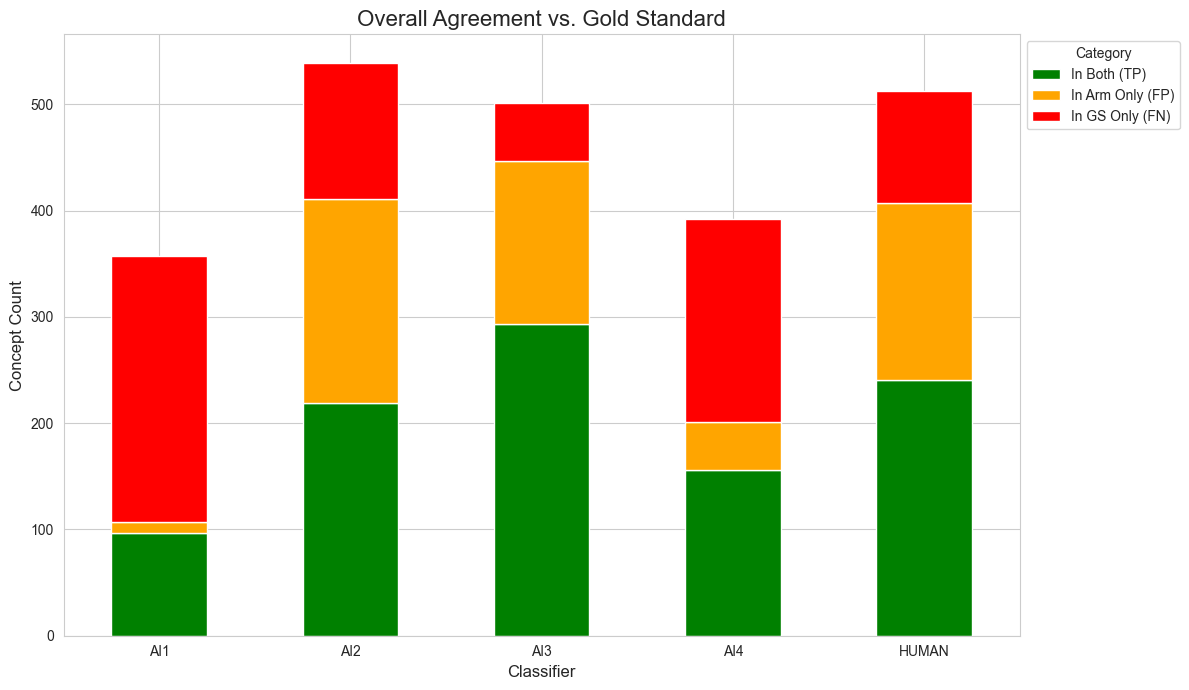


    PLOT 2: PER-DISEASE AGREEMENT


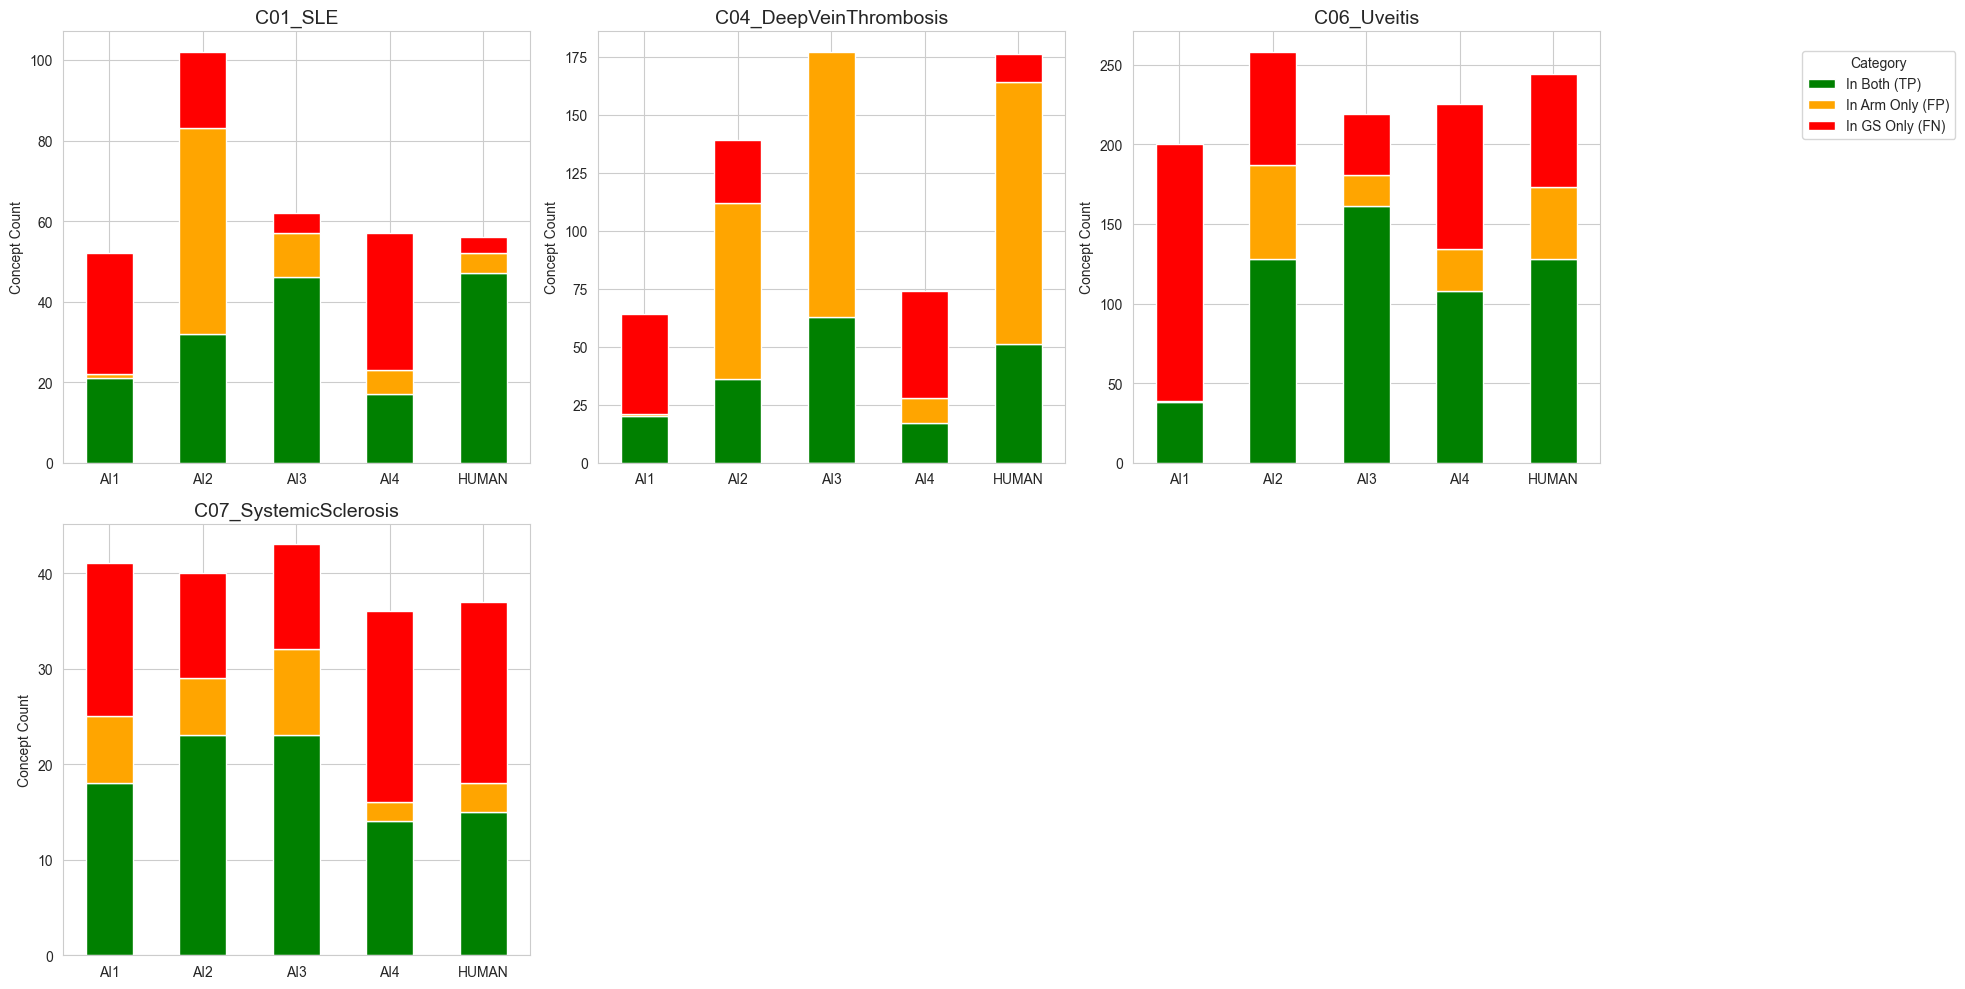

In [30]:
# --- 1. Prepare Data for Plotting ---

plot_data = []

# Add Overall data
for clf in classifier_columns:
    is_gold = df_items['gold']
    is_clf = df_items[clf]
    
    tp = (is_gold & is_clf).sum()
    fp = (~is_gold & is_clf).sum()
    fn = (is_gold & ~is_clf).sum()
    
    plot_data.append({'classifier': clf.upper(), 'task': 'Overall', 'type': 'In Both (TP)', 'count': tp})
    plot_data.append({'classifier': clf.upper(), 'task': 'Overall', 'type': 'In Arm Only (FP)', 'count': fp})
    plot_data.append({'classifier': clf.upper(), 'task': 'Overall', 'type': 'In GS Only (FN)', 'count': fn})

# Add Per-Disease data
for task_name, group_df in df_items.groupby('task_id'):
    for clf in classifier_columns:
        is_gold = group_df['gold']
        is_clf = group_df[clf]
        
        tp = (is_gold & is_clf).sum()
        fp = (~is_gold & is_clf).sum()
        fn = (is_gold & ~is_clf).sum()
        
        plot_data.append({'classifier': clf.upper(), 'task': task_name, 'type': 'In Both (TP)', 'count': tp})
        plot_data.append({'classifier': clf.upper(), 'task': task_name, 'type': 'In Arm Only (FP)', 'count': fp})
        plot_data.append({'classifier': clf.upper(), 'task': task_name, 'type': 'In GS Only (FN)', 'count': fn})

df_plot = pd.DataFrame(plot_data)

# Define the plotting order for the segments
segment_order = ['In Both (TP)', 'In Arm Only (FP)', 'In GS Only (FN)']
# Define a color palette
palette = {"In Both (TP)": "g", "In Arm Only (FP)": "orange", "In GS Only (FN)": "r"}


# --- 2. Plot Overall Agreement ---
print("\n" + "="*50)
print("    PLOT 1: OVERALL AGREEMENT (All Tasks)")
print("="*50)

df_plot_overall = df_plot[df_plot['task'] == 'Overall']
pivot_overall = df_plot_overall.pivot(index='classifier', columns='type', values='count')[segment_order]

pivot_overall.plot(kind='bar', stacked=True, color=palette, figsize=(12, 7))
plt.title('Overall Agreement vs. Gold Standard', fontsize=16)
plt.ylabel('Concept Count', fontsize=12)
plt.xlabel('Classifier', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Category', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


# --- 3. Plot Per-Disease Agreement ---
print("\n" + "="*50)
print("    PLOT 2: PER-DISEASE AGREEMENT")
print("="*50)

df_plot_per_disease = df_plot[df_plot['task'] != 'Overall']
tasks = df_plot_per_disease['task'].unique()
n_tasks = len(tasks)

if n_tasks > 0:
    n_cols = 3
    n_rows = (n_tasks + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5), squeeze=False)
    axes = axes.flatten()
    
    for i, task in enumerate(tasks):
        ax = axes[i]
        task_data = df_plot_per_disease[df_plot_per_disease['task'] == task]
        pivot_task = task_data.pivot(index='classifier', columns='type', values='count').reindex(columns=segment_order).fillna(0)
        
        pivot_task.plot(kind='bar', stacked=True, color=palette, ax=ax, legend=False)
        ax.set_title(task, fontsize=14)
        ax.set_ylabel('Concept Count')
        ax.set_xlabel(None)
        ax.tick_params(axis='x', rotation=0)
    
    # Add a single legend for the whole figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Category', loc='upper left', bbox_to_anchor=(1, 0.95))
    
    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make room for legend
    plt.show()
else:
    print("No per-disease data to plot.")
